In [142]:
from project.models.unet3d_fieldmap import UNet3DFieldmap
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from project.data import data_util
import numpy as np
from sklearn.metrics import mean_squared_error

In [143]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "/student/magnuschristensen/dev/fmdc/downloads/fmri-ckpts/29-03-2025_BS16/last-v3.ckpt"

In [144]:
model = UNet3DFieldmap.load_from_checkpoint(CHECKPOINT_PATH, map_location=torch.device(device), encoder_map_location=torch.device(device), device=device)
model.to(device)
model.eval()

UNet3DFieldmap(
  (model): UNet3D_2Module(
    (Conv3D_1): conv3D_block(
      (conv3D): Sequential(
        (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): ReLU(inplace=True)
      )
    )
    (Conv3D_2): conv3D_block(
      (conv3D): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_s

b0d image shape: (78, 78, 60, 360)
t1w image shape: (78, 78, 60)
Fieldmap image shape: (78, 78, 60, 2)


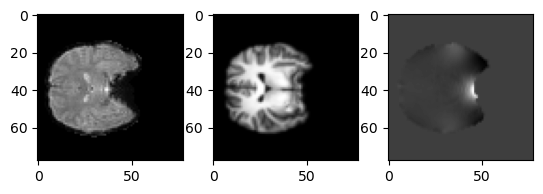

In [152]:
b0d = "/indirect/student/magnuschristensen/dev/fmdc/downloads/processed-datasets/test-processed/ds003835/sub-04/b0_d.nii.gz"
t1w = "/indirect/student/magnuschristensen/dev/fmdc/downloads/processed-datasets/test-processed/ds003835/sub-04/T1w.nii.gz"
fieldmap = "/indirect/student/magnuschristensen/dev/fmdc/downloads/processed-datasets/test-processed/ds003835/sub-04/field_map.nii.gz"

b0d_img = nib.load(b0d).get_fdata()
t1w_img = nib.load(t1w).get_fdata()
fieldmap_img = nib.load(fieldmap).get_fdata()

print(f"b0d image shape: {b0d_img.shape}")
print(f"t1w image shape: {t1w_img.shape}")
print(f"Fieldmap image shape: {fieldmap_img.shape}")

b0d_img_slice = b0d_img[..., b0d_img.shape[3] // 2]
fieldmap_slice = fieldmap_img[..., 0]

fig, axs = plt.subplots(1, 3)
axs[0].imshow(b0d_img_slice[..., b0d_img_slice.shape[2] // 2], cmap='grey')
axs[1].imshow(t1w_img[..., t1w_img.shape[2] // 2], cmap='grey')
axs[2].imshow(fieldmap_slice[..., fieldmap_slice.shape[2] // 2], cmap='grey')

In [154]:
t1 = data_util.get_nii_img(t1w)
func = data_util.get_nii_img(b0d)[..., b0d_img.shape[-1] // 2]
fmap = data_util.get_nii_img(fieldmap)[..., 0]
print(t1.shape, func.shape, fmap.shape)

(78, 78, 60) (78, 78, 60) (78, 78, 60)


In [155]:
t1_np = np.array(t1).transpose(2,0,1)
func_np = np.array(func).transpose(2,0,1)
t1_norm = data_util.normalize_img(t1_np, 150, 0, 1, -1)
max_img_b0_d = np.percentile(func_np, 99)
min_img_b0_d = 0
func_norm = data_util.normalize_img(func_np, max_img_b0_d, min_img_b0_d, 1, -1)
print(t1_norm.shape, func_norm.shape)
img_data = torch.stack((torch.from_numpy(func_norm).float().to(device), torch.from_numpy(t1_norm).float().to(device))).unsqueeze(0)
print(img_data.shape)

(60, 78, 78) (60, 78, 78)
torch.Size([1, 2, 60, 78, 78])


torch.Size([1, 1, 60, 78, 78])
torch.Size([60, 78, 78])
(60, 78, 78)
(78, 78, 60)


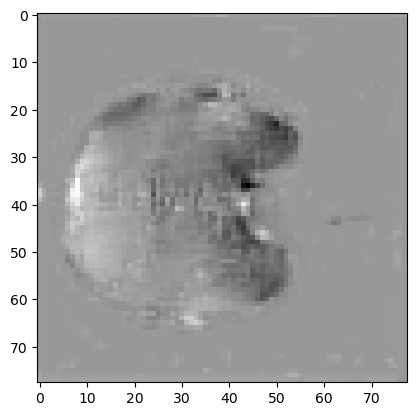

In [156]:
out = model(img_data)
print(out.shape)
out_squeezed = out.squeeze(0).squeeze(0)
print(out_squeezed.shape)
out_np = out_squeezed.detach().numpy()
print(out_np.shape)
fieldmap_out = out_np.transpose(1,2,0)
print(fieldmap_out.shape)
plt.imshow(fieldmap_out[..., fieldmap_out.shape[2] // 2], cmap="grey")

In [157]:
fieldmap_true = fieldmap_img[..., 0]
print(fieldmap_true.shape, fieldmap_out.shape)

(78, 78, 60) (78, 78, 60)


In [158]:
mse_loss = np.square(np.subtract(fieldmap_true, fieldmap_out)).mean()
print(mse_loss.mean())

2574.8510746495017
